In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.3
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/Real_Combine (1).csv')
df

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833
...,...,...,...,...,...,...,...,...,...
1088,18.1,24.0,11.2,1015.4,56.0,1.8,15.9,25.9,288.416667
1089,17.8,25.0,10.7,1015.8,54.0,2.3,9.4,22.2,256.833333
1090,13.9,24.5,11.4,1015.0,95.0,0.6,8.7,14.8,169.000000
1091,16.3,23.0,9.8,1016.9,78.0,1.1,7.4,16.5,186.041667


In [5]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 21.5 MB/s eta 0:00:00


In [6]:
!pip install --upgrade tensorflow

In [7]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

Using TensorFlow backend


In [8]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [10]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [11]:
def hyper_tune(param):
    model = keras.Sequential()
    for i in range(param.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=param.Int('Units_'+str(i), min_value=32, max_value=512, step=32), activation='tanh'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=keras.optimizers.Adam(param.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    return model


In [12]:
tuner = RandomSearch(
    hyper_tune,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    overwrite=True,
    project_name='Air Quality Index AQI'
)


In [13]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x,y, test_size=0.3, random_state =0)


In [14]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test,y_test))

Trial 5 Complete [00h 00m 35s]
val_mean_absolute_error: 64.79696400960286

Best val_mean_absolute_error So Far: 64.79696400960286
Total elapsed time: 00h 01m 42s


Epoch 1/5
24/24 [==============================] - 9s 46ms/step - loss: 91.0484 - mean_absolute_error: 91.0484 - val_loss: 72.3947 - val_mean_absolute_error: 72.3947
Epoch 2/5
24/24 [==============================] - 1s 35ms/step - loss: 73.4312 - mean_absolute_error: 73.4312 - val_loss: 65.6818 - val_mean_absolute_error: 65.6818
Epoch 3/5
24/24 [==============================] - 1s 32ms/step - loss: 67.8456 - mean_absolute_error: 67.8456 - val_loss: 64.7493 - val_mean_absolute_error: 64.7493
Epoch 4/5
24/24 [==============================] - 1s 30ms/step - loss: 66.4924 - mean_absolute_error: 66.4924 - val_loss: 65.0232 - val_mean_absolute_error: 65.0232
Epoch 5/5
24/24 [==============================] - 1s 34ms/step - loss: 66.2836 - mean_absolute_error: 66.2836 - val_loss: 65.3820 - val_mean_absolute_error: 65.3820


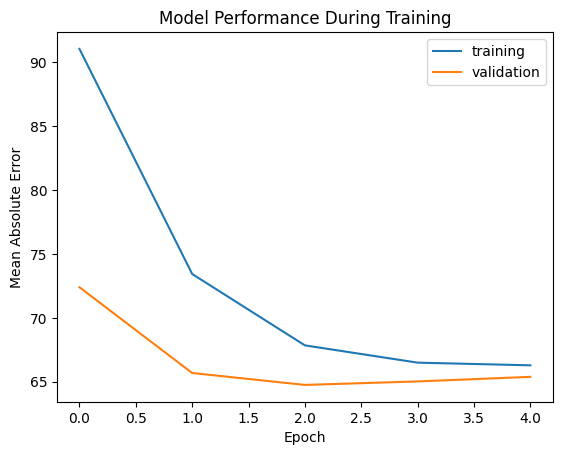

In [15]:
import matplotlib.pyplot as plt

#Get the best Hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(1)[0]

#Build the Model witht he best hyperparameters
model=hyper_tune(best_hps)

#Train the model with the best hyperparameters on the full training set
history = model.fit(x_train,y_train , epochs=5 ,validation_data = (x_test,y_test))

#Plot the Training and Validation Metrics for each Epoch
plt.plot(history.history['mean_absolute_error'] , label='training')
plt.plot(history.history['val_mean_absolute_error'] , label='validation')
plt.title('Model Performance During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()